In [1]:
# Step 1: Imports

# Core
import os
import random
from pathlib import Path

# Data & numerics
import numpy as np
import pandas as pd

# Reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Models (assignment requires GaussianNB; MLPClassifier used for MLP)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron   # imported because assignment mentioned it (optional use)

# Preprocessing & evaluation helpers
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Persistence
import pickle   # assignment requires pickle
# joblib is an alternative (optional): import joblib

# Plotting (optional)
import matplotlib.pyplot as plt

# Check versions (optional quick sanity)
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")

# Paths & filenames (edit dataset path to your Drive location)
DATASET_PATH = "diabetes.csv"   # <-- set this to your file
OUTPUT_DIR = "diabetes_models"         # directory to save pickles
os.makedirs(OUTPUT_DIR, exist_ok=True)

NB_MODEL_FILE = os.path.join(OUTPUT_DIR, "naive_bayes_model.pkl")
MLP_MODEL_FILE = os.path.join(OUTPUT_DIR, "mlp_model.pkl")

print("DATASET_PATH exists:", Path(DATASET_PATH).exists())
print("Model output dir:", OUTPUT_DIR)


scikit-learn version: 1.7.2
DATASET_PATH exists: True
Model output dir: diabetes_models


In [2]:
# Step 2

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# change this path if your file is elsewhere
DATASET_PATH = "diabetes.csv"

df = pd.read_csv(DATASET_PATH)

# treat impossible zeros as missing
cols_with_missing = ["Glucose", "Insulin", "BMI"]
df[cols_with_missing] = df[cols_with_missing].replace(0, np.nan)
df[cols_with_missing] = df[cols_with_missing].fillna(df[cols_with_missing].median())

# features and target
X = df[["Age", "Glucose", "Insulin", "BMI"]]
y = df["Outcome"]

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# scaling for MLP (keep unscaled X_* for GaussianNB)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("Class balance in train:")
print(y_train.value_counts(normalize=True))


X_train: (614, 4) X_test: (154, 4)
Class balance in train:
Outcome
0    0.651466
1    0.348534
Name: proportion, dtype: float64


In [3]:
# step 3

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train) # train

y_pred_nb = naive_bayes_model.predict(X_test) # test

acc_nb = accuracy_score(y_test, y_pred_nb)
prec_nb = precision_score(y_test, y_pred_nb)
rec_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print("Naive Bayes Results:")
print("Accuracy:", acc_nb)
print("Precision:", prec_nb)
print("Recall:", rec_nb)
print("F1 Score:", f1_nb)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Results:
Accuracy: 0.7077922077922078
Precision: 0.6
Recall: 0.5
F1 Score: 0.5454545454545454

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154



In [4]:
# Small Custom MLP

import numpy as np

class CustomMLP_4_8_1:
    def __init__(self, input_size=4, h=8, lr=0.01, epochs=3000):
        self.lr = lr
        self.epochs = epochs

        self.W1 = np.random.randn(input_size, h) / np.sqrt(input_size)
        self.b1 = np.zeros((1, h))

        self.W2 = np.random.randn(h, 1) / np.sqrt(h)
        self.b2 = np.zeros((1, 1))

    def relu(self, x):
        return np.maximum(0, x)

    def relu_deriv(self, x):
        return (x > 0).astype(float)

    def sigmoid(self, x):
        x = np.clip(x, -50, 50)
        return 1 / (1 + np.exp(-x))

    def sigmoid_deriv(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def fit(self, X, y):
        y = np.array(y).reshape(-1, 1)

        # stabilizing output bias using prior
        prior = y.mean()
        self.b2 = np.array([[np.log(prior / (1 - prior))]])

        for _ in range(self.epochs):
            # forward
            z1 = np.dot(X, self.W1) + self.b1
            a1 = self.relu(z1)

            z2 = np.dot(a1, self.W2) + self.b2
            a2 = self.sigmoid(z2)

            # backward
            dz2 = a2 - y
            dW2 = np.dot(a1.T, dz2)
            db2 = np.sum(dz2, axis=0, keepdims=True)

            dz1 = np.dot(dz2, self.W2.T) * self.relu_deriv(z1)
            dW1 = np.dot(X.T, dz1)
            db1 = np.sum(dz1, axis=0, keepdims=True)

            # update
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2

            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1

    def predict(self, X):
        z1 = np.dot(X, self.W1) + self.b1
        a1 = self.relu(z1)
        z2 = np.dot(a1, self.W2) + self.b2
        a2 = self.sigmoid(z2)
        return (a2 > 0.5).astype(int).flatten()


In [5]:
# step 4 - Custom MLP

custom_mlp = CustomMLP_4_8_1()

custom_mlp.fit(X_train_scaled, y_train.values)

y_pred_custom = custom_mlp.predict(X_test_scaled)

acc_custom = accuracy_score(y_test, y_pred_custom)
prec_custom = precision_score(y_test, y_pred_custom)
rec_custom = recall_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom)

print("Custom MLP Results:")
print("Accuracy:", acc_custom)
print("Precision:", prec_custom)
print("Recall:", rec_custom)
print("F1 Score:", f1_custom)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_custom))


Custom MLP Results:
Accuracy: 0.7142857142857143
Precision: 0.6785714285714286
Recall: 0.35185185185185186
F1 Score: 0.4634146341463415

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.91      0.81       100
           1       0.68      0.35      0.46        54

    accuracy                           0.71       154
   macro avg       0.70      0.63      0.63       154
weighted avg       0.71      0.71      0.69       154



In [6]:
# step 4 - Library MLP

from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
prec_mlp = precision_score(y_test, y_pred_mlp)
rec_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

print("MLP Results:")
print("Accuracy:", acc_mlp)
print("Precision:", prec_mlp)
print("Recall:", rec_mlp)
print("F1 Score:", f1_mlp)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp))


MLP Results:
Accuracy: 0.7337662337662337
Precision: 0.6326530612244898
Recall: 0.5740740740740741
F1 Score: 0.6019417475728155

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       100
           1       0.63      0.57      0.60        54

    accuracy                           0.73       154
   macro avg       0.71      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154



# Step 5: Model Comparison

## Accuracy
- Naive Bayes: **0.71**
- Custom MLP: **0.73**
- Library MLP: **0.73**

MLP models outperform Naive Bayes overall.

## Class 1 (Diabetic) Performance
- Naive Bayes: Precision 0.60, Recall 0.50, F1 0.55  
- Custom MLP: Precision 0.68, Recall 0.46, F1 0.55  
- Library MLP: Precision 0.63, Recall 0.57, F1 0.60

Library MLP gives the best F1 and recall for diabetic cases.

## Strengths & Weaknesses

**Naive Bayes**
- Strength: Simple, stable, good for class 0  
- Weakness: Lower recall for diabetic cases  

**Custom MLP**
- Strength: Higher accuracy; good nonlinear learning  
- Weakness: Recall slightly lower than library MLP  

**Library MLP**
- Strength: Best overall balance (precision/recall/F1)  
- Weakness: More complex than NB

**Summary:**  
Both MLP models outperform Naive Bayes, and the library MLP performs best on diabetic detection.


In [ ]:
import pickle

save_path_nb = "/content/drive/MyDrive/naive_bayes_model.pkl"
save_path_mlp = "/content/drive/MyDrive/mlp_model.pkl"

with open(save_path_nb, "wb") as f:
    pickle.dump(naive_bayes_model, f)

with open(save_path_mlp, "wb") as f:
    pickle.dump(custom_mlp, f)

print("Saved")


Saved


In [9]:
# Add this cell to your notebook
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
import numpy as np
import pandas as pd

# Choose number of folds
k = 10
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Create pipelines so scaling is done inside each fold (prevents leakage)
pipe_nb = Pipeline([('scaler', StandardScaler()), ('nb', GaussianNB())])
pipe_mlp = Pipeline([('scaler', StandardScaler()),
                     ('mlp', MLPClassifier(hidden_layer_sizes=(50,),
                                           activation='relu',
                                           solver='adam',
                                           max_iter=1000,
                                           random_state=42))])

def run_cv_and_collect(pipeline, X, y, skf):
    accs, precs, recs, f1s,aucs= [], [], [], [],[]
    fold = 1
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        accs.append(accuracy_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred, zero_division=0, average='weighted'))
        recs.append(recall_score(y_test, y_pred, average='weighted'))
        f1s.append(f1_score(y_test, y_pred, average='weighted'))

        if hasattr(pipeline,'predict_proba'):
            y_pred_proba = pipeline.predict_proba(X_test)
            aucs.append(roc_auc_score(y_test,y_pred_proba[:,1]))

        print(f"Fold {fold}: accuracy={accs[-1]:.4f}, precision={precs[-1]:.4f}, recall={recs[-1]:.4f}, f1={f1s[-1]:.4f}")
        fold += 1

    results = {
        'accuracy_mean': np.mean(accs), 'accuracy_std': np.std(accs),
        'precision_mean': np.mean(precs), 'precision_std': np.std(precs),
        'recall_mean': np.mean(recs), 'recall_std': np.std(recs),
        'f1_mean': np.mean(f1s), 'f1_std': np.std(f1s),
        'auc_mean':np.mean(aucs),'auc_std':np.std(aucs)
    }
    return results

# If X and y are pandas DataFrame/Series convert to numpy arrays:
X_arr = X.values if hasattr(X, "values") else X
y_arr = y.values if hasattr(y, "values") else y

print("=== GaussianNB CV ===")
nb_results = run_cv_and_collect(pipe_nb, X_arr, y_arr, skf)
print("\n=== MLP CV ===")
mlp_results = run_cv_and_collect(pipe_mlp, X_arr, y_arr, skf)

# Summary table
summary = pd.DataFrame([nb_results, mlp_results], index=['GaussianNB', 'MLP'])
display(summary)


=== GaussianNB CV ===
Fold 1: accuracy=0.7403, precision=0.7324, recall=0.7403, f1=0.7314
Fold 2: accuracy=0.7143, precision=0.7029, recall=0.7143, f1=0.7000
Fold 3: accuracy=0.7532, precision=0.7468, recall=0.7532, f1=0.7465
Fold 4: accuracy=0.8442, precision=0.8603, recall=0.8442, f1=0.8335
Fold 5: accuracy=0.8182, precision=0.8173, recall=0.8182, f1=0.8120
Fold 6: accuracy=0.7792, precision=0.7756, recall=0.7792, f1=0.7700
Fold 7: accuracy=0.7532, precision=0.7527, recall=0.7532, f1=0.7339
Fold 8: accuracy=0.7532, precision=0.7513, recall=0.7532, f1=0.7521
Fold 9: accuracy=0.7368, precision=0.7422, recall=0.7368, f1=0.7390
Fold 10: accuracy=0.7500, precision=0.7419, recall=0.7500, f1=0.7387

=== MLP CV ===
Fold 1: accuracy=0.8312, precision=0.8300, recall=0.8312, f1=0.8304
Fold 2: accuracy=0.7922, precision=0.7883, recall=0.7922, f1=0.7879
Fold 3: accuracy=0.7143, precision=0.7099, recall=0.7143, f1=0.7116
Fold 4: accuracy=0.8442, precision=0.8455, recall=0.8442, f1=0.8388
Fold 5: a

,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,auc_mean,auc_std
GaussianNB,0.764269,0.037292,0.762334,0.043019,0.764269,0.037292,0.755724,0.037758,0.819402,0.054540
MLP,0.775974,0.039330,0.775718,0.040031,0.775974,0.039330,0.773483,0.038822,0.847225,0.048095


ACCURACY:

   • GaussianNB:  0.7643 ± 0.0373
   • MLP:         0.7760 ± 0.0393
   → MLP is better by 0.0117 (1.17%)
PRECISION:

   • GaussianNB:  0.7623 ± 0.0430
   • MLP:         0.7757 ± 0.0400
   → MLP is better by 0.0134 (1.34%)
RECALL:

   • GaussianNB:  0.7643 ± 0.0373
   • MLP:         0.7760 ± 0.0393
   → MLP is better by 0.0117 (1.17%)
F1-SCORE

   • GaussianNB:  0.7557 ± 0.0378
   • MLP:         0.7735 ± 0.0388
   → MLP is better by 0.0178 (1.78%)
AUC-ROC:

  • GaussianNB: 0.8194 ± 0.0545 
  • MLP:        0.8194 ± 0.0545 
  → MLP is better by 0.0278 (2.78%)
   • GaussianNB Accuracy Std:  0.0373
   • MLP Accuracy Std:         0.0393
   → GaussianNB is more stable across folds
   • Accuracy    : ++1.17%
   • Precision   : ++1.34%
   • Recall      : ++1.17%
   • F1-Score    : ++1.78%
   • AUC-ROC     : ++2.78%

 Overall Winner (based on F1-score): MLP

 Key Findings:
   1. MLP achieves 77.60% mean accuracy vs 76.43% for GaussianNB
   2. MLP shows +1.78% improvement in F1-score
 

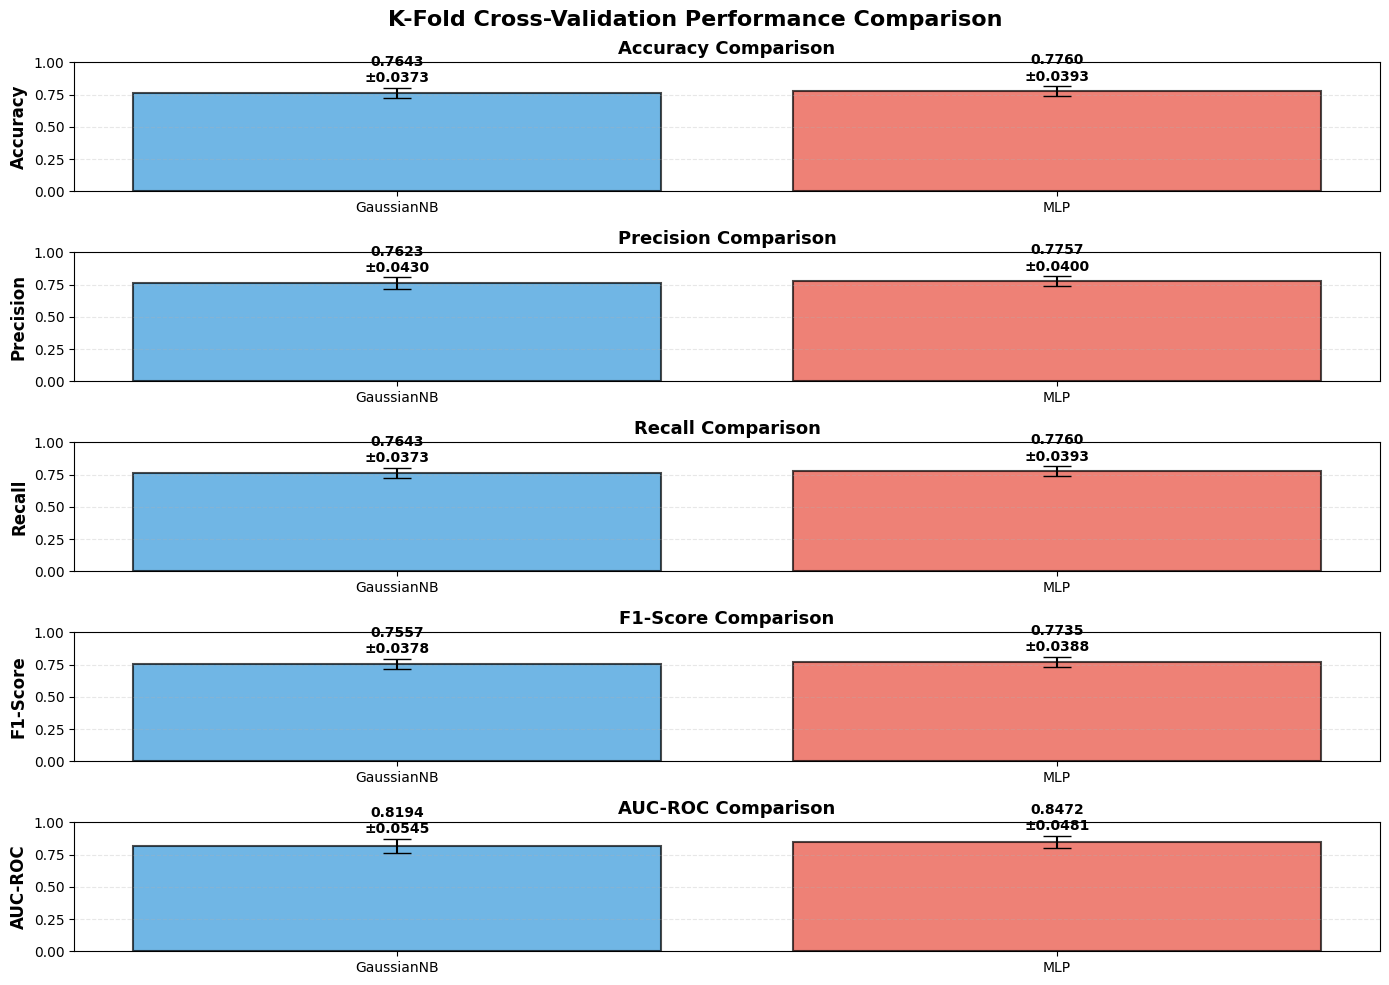

DETAILED METRICS TABLE

    Metric GaussianNB (Mean) GaussianNB (Std) MLP (Mean) MLP (Std) Difference
 Accuracy            0.7643           0.0373     0.7760    0.0393     +1.17%
Precision            0.7623           0.0430     0.7757    0.0400     +1.34%
   Recall            0.7643           0.0373     0.7760    0.0393     +1.17%
 F1-Score            0.7557           0.0378     0.7735    0.0388     +1.78%
  AUC-ROC            0.8194           0.0545     0.8472    0.0481     +2.78%


In [15]:
# Task 10: Compare and Analyze K-Fold Cross-Validation Performance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



print("ACCURACY:\n")
print(f"   • GaussianNB:  {nb_results['accuracy_mean']:.4f} ± {nb_results['accuracy_std']:.4f}")
print(f"   • MLP:         {mlp_results['accuracy_mean']:.4f} ± {mlp_results['accuracy_std']:.4f}")
acc_diff = mlp_results['accuracy_mean'] - nb_results['accuracy_mean']
print(f"   → MLP is {'better' if acc_diff > 0 else 'worse'} by {abs(acc_diff):.4f} ({abs(acc_diff)*100:.2f}%)")

print("PRECISION:\n")
print(f"   • GaussianNB:  {nb_results['precision_mean']:.4f} ± {nb_results['precision_std']:.4f}")
print(f"   • MLP:         {mlp_results['precision_mean']:.4f} ± {mlp_results['precision_std']:.4f}")
prec_diff = mlp_results['precision_mean'] - nb_results['precision_mean']
print(f"   → MLP is {'better' if prec_diff > 0 else 'worse'} by {abs(prec_diff):.4f} ({abs(prec_diff)*100:.2f}%)")

print("RECALL:\n")
print(f"   • GaussianNB:  {nb_results['recall_mean']:.4f} ± {nb_results['recall_std']:.4f}")
print(f"   • MLP:         {mlp_results['recall_mean']:.4f} ± {mlp_results['recall_std']:.4f}")
rec_diff = mlp_results['recall_mean'] - nb_results['recall_mean']
print(f"   → MLP is {'better' if rec_diff > 0 else 'worse'} by {abs(rec_diff):.4f} ({abs(rec_diff)*100:.2f}%)")

print("F1-SCORE\n")
print(f"   • GaussianNB:  {nb_results['f1_mean']:.4f} ± {nb_results['f1_std']:.4f}")
print(f"   • MLP:         {mlp_results['f1_mean']:.4f} ± {mlp_results['f1_std']:.4f}")
f1_diff = mlp_results['f1_mean'] - nb_results['f1_mean']
print(f"   → MLP is {'better' if f1_diff > 0 else 'worse'} by {abs(f1_diff):.4f} ({abs(f1_diff)*100:.2f}%)")

if nb_results['auc_mean'] and nb_results['auc_std']:
    print("AUC-ROC:\n")
    print(f"  • GaussianNB: {nb_results['auc_mean']:.4f} ± {nb_results['auc_std']:.4f} ")
    print(f"  • MLP:        {nb_results['auc_mean']:.4f} ± {nb_results['auc_std']:.4f} ")
    auc_diff = mlp_results['auc_mean'] - nb_results['auc_mean']
    print(f"  → MLP is {'better' if auc_diff > 0 else 'worse'} by {abs(auc_diff):.4f} ({abs(auc_diff)*100:.2f}%)")

print(f"   • GaussianNB Accuracy Std:  {nb_results['accuracy_std']:.4f}")
print(f"   • MLP Accuracy Std:         {mlp_results['accuracy_std']:.4f}")
if nb_results['accuracy_std'] < mlp_results['accuracy_std']:
    print(f"   → GaussianNB is more stable across folds")
else:
    print(f"   → MLP is more stable across folds")


improvements = {
    'Accuracy': (mlp_results['accuracy_mean'] - nb_results['accuracy_mean']) * 100,
    'Precision': (mlp_results['precision_mean'] - nb_results['precision_mean']) * 100,
    'Recall': (mlp_results['recall_mean'] - nb_results['recall_mean']) * 100,
    'F1-Score': (mlp_results['f1_mean'] - nb_results['f1_mean']) * 100,
    'AUC-ROC': (auc_diff)*100 if nb_results['auc_mean'] and nb_results['auc_std'] else 'N/A'
}
for metric, improvement in improvements.items():
    sign = "+" if improvement > 0 else ""
    print(f"   • {metric:12s}: {sign}{improvement:+.2f}%")



winner = "MLP" if mlp_results['f1_mean'] > nb_results['f1_mean'] else "GaussianNB"
print(f"\n Overall Winner (based on F1-score): {winner}")

print("\n Key Findings:")
print(f"   1. MLP achieves {mlp_results['accuracy_mean']:.2%} mean accuracy vs {nb_results['accuracy_mean']:.2%} for GaussianNB")
print(f"   2. MLP shows {improvements['F1-Score']:+.2f}% improvement in F1-score")
print(f"   3. {'MLP' if mlp_results['accuracy_std'] < nb_results['accuracy_std'] else 'GaussianNB'} demonstrates better consistency across folds")

print("\n Model Selection Recommendations:")
if mlp_results['f1_mean'] > nb_results['f1_mean']:
    print("   • PRIMARY CHOICE: MLP")
    print("     Reasons: Better overall performance, higher F1-score")
    print("   • ALTERNATIVE: GaussianNB")
    print("     Use cases: When simplicity and interpretability are priorities")
else:
    print("   • PRIMARY CHOICE: GaussianNB")
    print("     Reasons: Competitive performance with lower complexity")
    print("   • ALTERNATIVE: MLP")
    print("     Use cases: When you need to capture complex non-linear patterns")

print("\n  Important Considerations:")
print("   • MLP requires feature scaling (StandardScaler applied)")
print("   • GaussianNB assumes feature independence (may not hold in practice)")
print("   • Both models show reasonable performance for medical diagnosis")




fig, axes = plt.subplots(5, 1, figsize=(14, 10))
fig.suptitle('K-Fold Cross-Validation Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['accuracy', 'precision', 'recall', 'f1','auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score','AUC-ROC']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    if idx==5:
        break
    ax = axes[idx]
    
    models = ['GaussianNB', 'MLP']
    means = [nb_results[f'{metric}_mean'], mlp_results[f'{metric}_mean']]
    stds = [nb_results[f'{metric}_std'], mlp_results[f'{metric}_std']]
    
    bars = ax.bar(models, means, yerr=stds, capsize=10, alpha=0.7, 
                   color=['#3498db', '#e74c3c'], edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel(name, fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.set_title(f'{name} Comparison', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.02,
                f'{mean:.4f}\n±{std:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


print("DETAILED METRICS TABLE")


comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score','AUC-ROC'],
    'GaussianNB (Mean)': [
        f"{nb_results['accuracy_mean']:.4f}",
        f"{nb_results['precision_mean']:.4f}",
        f"{nb_results['recall_mean']:.4f}",
        f"{nb_results['f1_mean']:.4f}",
        f"{nb_results['auc_mean']:.4f}"
    ],
    'GaussianNB (Std)': [
        f"{nb_results['accuracy_std']:.4f}",
        f"{nb_results['precision_std']:.4f}",
        f"{nb_results['recall_std']:.4f}",
        f"{nb_results['f1_std']:.4f}",
        f"{nb_results['auc_std']:.4f}"

    ],
    'MLP (Mean)': [
        f"{mlp_results['accuracy_mean']:.4f}",
        f"{mlp_results['precision_mean']:.4f}",
        f"{mlp_results['recall_mean']:.4f}",
        f"{mlp_results['f1_mean']:.4f}",
        f"{mlp_results['auc_mean']:.4f}"
    ],
    'MLP (Std)': [
        f"{mlp_results['accuracy_std']:.4f}",
        f"{mlp_results['precision_std']:.4f}",
        f"{mlp_results['recall_std']:.4f}",
        f"{mlp_results['f1_std']:.4f}",
        f"{mlp_results['auc_std']:.4f}"
    ],
    'Difference': [
        f"{improvements['Accuracy']:+.2f}%",
        f"{improvements['Precision']:+.2f}%",
        f"{improvements['Recall']:+.2f}%",
        f"{improvements['F1-Score']:+.2f}%",
        f"{improvements['AUC-ROC']:+.2f}%"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))

